In [1]:
# Replace part of the OUTPUT_PATH to create a new folder 
# for the detection results
EXPERIMENT_NAME= "Temp4"
OUTPUT_PATH = EXPERIMENT_NAME + "/LoanApplications_Offline/"
NEW_OUTPUT_PATH = EXPERIMENT_NAME + "/LoanApplications_Offline__DETECTION/"
OUTPUT_RESULTS = EXPERIMENT_NAME + "/Results/"

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from tqdm.notebook import tqdm_notebook
import time
import ast

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, parallel_backend

import random
random.seed(42)

import itertools

import os
import glob

import gc
gc.enable()

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 

from copy import deepcopy

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    # If the string contains any of the values
    # from the list 'lista'
    for l in lista:
        if l in string:
            return True
    return False

In [4]:
# List log files
logs = insensitive_glob(r"../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")
logs = [x.replace('\\', '/') for x in logs if "2.5" not in x]
# logs = [x for x in logs if "2.5" not in x]

In [53]:
# reference objects and map them to strings in dict 
# used in further methods
objects = {
    "model": {
        "kmeans_k2": KMeans(n_clusters=2, random_state=42)
#         , "kmeans_k4": KMeans(n_clusters=4, random_state=42)
        
#         ,"DBSCAN__eps5ms3met=man": DBSCAN(eps=5, min_samples=3, metric='manhattan')
        ,"DBSCAN_eps6ms3met=man": DBSCAN(eps=6, min_samples=3, metric='manhattan')
        
        , "HDBSCAN_ep05met=euc": hdbscan.HDBSCAN(
                    metric='euclidean'
                    , gen_min_span_tree=True
                    , min_cluster_size= 10
                    , min_samples= 10
                    , cluster_selection_epsilon=0.5
                    , algorithm="generic"
                  )
        
    }
    
    , "representation": {
        "activity_binary": lr.get_binary_representation,
        "activity_freq": lr.get_frequency_representation,
        
        "transitions_binary": lr.get_binary_transitions_representation,
        "transitions_freq": lr.get_frequency_transitions_representation,
        
        "activity_tfidf": lr.get_tfidf_representation,
        "transitions_tfidf": lr.get_tfidf_transitions_representation,
        
        "act_trans_freq": lr.get_activity_transitions_frequency_representation,
        "act_trans_binary": lr.get_activity_transitions_binary_representation
    }
    
    , "dim_reduct": {
        "LLE3D": LocallyLinearEmbedding(
                    n_neighbors= 99 
                    , n_components=3
                    , reg=0.001
                    , eigen_solver='auto' #{'auto', 'arpack', 'dense'}
                    , tol=1e-06
                    , max_iter=500
                    , method='ltsa' #('standard', 'hessian', 'modified' or 'ltsa')
                    , hessian_tol=0.0001
                    , modified_tol=1e-12
                    , neighbors_algorithm='auto' #['auto'|'brute'|'kd_tree'|'ball_tree']
                    , random_state=42)
        , "LLE2D": LocallyLinearEmbedding(
                    n_neighbors= 99
                    , n_components=2
                    , reg=0.001
                    , eigen_solver='auto' #{'auto', 'arpack', 'dense'}
                    , tol=1e-06
                    , max_iter=500
                    , method='ltsa' #('standard', 'hessian', 'modified' or 'ltsa')
                    , hessian_tol=0.0001
                    , modified_tol=1e-12
                    , neighbors_algorithm='auto' #['auto'|'brute'|'kd_tree'|'ball_tree']
                    , random_state=42)
#         , "None": None
    }

}

In [6]:
distance_list=['euclidean']#, 'hamming','cityblock', 'jaccard', 'cosine']

In [7]:
# change patterns and they supported representations
activity_binary_drifts = ["cb", "cf", "cm", "fr", "pm", "re", "rp"]
activity_frequency_drifts = activity_binary_drifts + ["cp", "lp"]

transitions_binary_drifts = activity_frequency_drifts + ["cd", "pl", "sw"] #+ ["IOR", "IRO", "OIR", "ORI", "RIO", "ROI"]
transitions_frequency_drifts = transitions_binary_drifts

activity_tfidf_drifts = transitions_binary_drifts
transitions_tfidf_drifts = transitions_binary_drifts

activity_transitions_frequency_drifts = transitions_binary_drifts
activity_transitions_binary_drifts = transitions_binary_drifts

### Pipeline Offline Clustering

In [8]:
def read_file_and_run_clustering_pipeline(args, return_result=False):
    """
    Read an event log file, represent it into a feature vector space and
    run the trace clustering method over windows. This method outputs results
    as gzip csv files into the "OUTPUT_PATH" folder, or return the result 
    as DataFrame when return_result = True.
    
    Parameters:
    -----------
        args (dict): Dictionary with the parameters and the log_file path
            requiring the following keys:
                example = {
                    'log': <PATH TO LOG_FILE>,
                    'representation': <KEY TO REPRESENTATIONS IN 'objects'>,
                    'parameters': [{
                        'model': <KEY TO MODEL IN 'objects'>, 
                        'sliding_window': <WHETHER TO USE SLIDING WINDOW>,
                        'window_size': <SIZE OF TRACE WINDOW TO USE>,
                        'sliding_step': <STEP OF SLIDING WINDOW>
                    }
        return_result (bool): Whether to return the result as DataFrame
            
    """
    
    # Treat file name to structure size and log type
    split = args["log"].split("/")
    
    # Parse change pattern name
    cd_name = split[-2]
    log_name = split[-1][:-5]
    
    # Set up true drifts indexes
#     y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    
    try:
        # Read log and apply trace representation technique
        log_read = pm.all_prep(open(args["log"]))
        tokens = lr.get_traces_as_tokens(log_read)
#         df = objects["representation"][args["representation"]](log_read)

        # Parse size of the event_log
#         log_size = log_name.replace(cd_name, "").replace("new_", "")
#         log_size = int(float(log_size.replace("k", "")) * 1000)
        log_size = len(tokens)
        
        for p in args["parameters"]:
            # String to identify results when exporting files
            tipo_mudanca = cd_name.replace("new_", "")
            
            cached_info = "-".join([
                tipo_mudanca,
                str(log_size),
                p["model"],
                args["representation"],
                p["dim_reduct"],
                str(p["window_size"]),
                str(p["sliding_step"])
            ])
            
            print(cached_info)
            
            # If already exists, return if needed
            file_to_export = OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip'
            if os.path.exists(file_to_export):
                if return_result:
                    r_ = pd.read_pickle(
                        file_to_export,
                        compression='gzip'
                    )
                    return r_
                else:
                    continue
            
            # If file does not exists, run trace clustering step and export file
            all_metrics, X = off_sc.run_offline_clustering_window(
                tokens,
                objects["representation"][args["representation"]],
                objects["dim_reduct"][p["dim_reduct"]],
                sk_clone(objects["model"][p["model"]]),
                distance_list,
                p["window_size"],
#                 p["sliding_window"],
                sliding_step=p['sliding_step']
            )
            
            if return_result:
                return all_metrics
            else:
                try:
                    os.makedirs(OUTPUT_PATH + tipo_mudanca + '/')
                except:
                    pass
                all_metrics.to_pickle(file_to_export, compression="gzip")

            gc.collect()
    except Exception as e:
        raise e
#     print("###################################################################")

#### Run pipeline for specific case(s)

In [9]:
# read_file_and_run_clustering_pipeline({
#     'log': logs[0],
#     'representation': 'activity_binary',
#     'parameters': [{
#         'model': 'HDBSCAN__noparams', 
#         'sliding_window': False,
#         'window_size': 75,
#         'sliding_step': 1
#     }]
# }, return_result=True)

### Run Experiments with several parameters combinations

In [10]:
# Trace clustering parameters
grid_parameters = list(ParameterGrid({
#     "sliding_window": [False]    
    "window_size": [100, 200]
    ,'sliding_step': [100]
    ,"model": list(objects['model'].keys())
    , "dim_reduct": list(objects['dim_reduct'].keys())
}))

# Trace vector representations
grid_logs = list(ParameterGrid([
    { "log": [x for x in logs if if_any(x, activity_binary_drifts)],
        "representation": ["activity_binary"]}
    ,{"log": [x for x in logs if if_any(x, activity_frequency_drifts)],
        "representation": ["activity_freq"]}
    
    ,{ "log": [x for x in logs if if_any(x, transitions_binary_drifts)],
        "representation": ["transitions_binary"]}
    ,{ "log": [x for x in logs if if_any(x, transitions_frequency_drifts)],
        "representation": ["transitions_freq"]}
    
    ,{ "log": [x for x in logs if if_any(x, activity_tfidf_drifts)],
        "representation": ["activity_tfidf"]}
    ,{"log": [x for x in logs if if_any(x, transitions_tfidf_drifts)],
        "representation": ["transitions_tfidf"]}
    
    ,{"log": [x for x in logs if if_any(x, activity_transitions_frequency_drifts)],
        "representation": ["act_trans_freq"]}
    ,{"log": [x for x in logs if if_any(x, activity_transitions_binary_drifts)],
        "representation": ["act_trans_binary"]}
]))

# Combining all parameters
combs = []
for x in grid_logs:
    dic = x.copy()
    dic['parameters'] = grid_parameters
    
    combs.append(dic)

len(combs), len(grid_parameters), len(combs) * len(grid_parameters) 

(264, 12, 3168)

#### Run parallely

In [11]:
final_resp = Parallel(n_jobs=-1)(
    delayed(read_file_and_run_clustering_pipeline)(comb) for comb in tqdm_notebook(combs)
)
gc.collect()

2070

### Detection Pipeline

In [12]:
# Drift detection parameters
drift_config = list(ParameterGrid([
    {
        "rolling_window": [3]
        ,"std_tolerance": [2, 3]#[1, 1.5, 2, 2.5, 3]
        ,'min_tol': [0.1, 0.05]#[0.0025, 0.025, 0.25] #[0.01, 0.007, 0.005, 0.003] 
    }
]))
print(len(drift_config))

4


In [13]:
# List all files obtained after the trace clustering pipeline

clusterizacoes = glob.glob(OUTPUT_PATH + "*/*.pickle.gzip")
print(len(clusterizacoes))

3168


In [14]:
# Combinations to run

combs_deteccao = []
for log in clusterizacoes:
    combs_deteccao.append({
        'input': log,
        'combinations': drift_config
    })
print(len(clusterizacoes)*len(drift_config))

12672


In [15]:
def drift_detect_pipeline(args, return_results=False):
    """
        Runs the drift detection method based on the output from the trace
        clustering pipeline for different combination of parameters and every
        feature from tracking the trace clustering evolution. The
        outputs are into a new folder named by the NEW_OUTPUT_PATH variable in 
        gzip csv files.
        
        Parameters:
        -----------
            args (dict): Dictionary with the parameters and the log_file path
                requiring the following keys:
                    example = {
                    }
    """
    # Read file
    all_metrics = pd.read_pickle(args["input"], compression='gzip')
    
    # Parse information from file name
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    args.update({
        "tipo_mudanca": path_file[-1].split('-')[0],
        "log_size": int(path_file[-1].split('-')[1]),
        "model": path_file[-1].split('-')[2],
        "representation": path_file[-1].split('-')[3], # "_".join(path_file[-1].split('-')[5:-3]),
        "dim_reduct": path_file[-1].split('-')[4],
        "window_size": path_file[-1].split('-')[5],
        "sliding_window": path_file[-1].split('-')[6]
    })
                              
    
    # Run detection for every combination of parameter    
    for combination in args['combinations']:
        c = deepcopy(combination)
        c.update({
            'input': args['input'],
            'tipo_mudanca': args['tipo_mudanca'],
            'log_size': args['log_size'],
            'model': args['model'],
            'representation': args['representation'],
            'dim_reduct': args['dim_reduct'],
            'window_size': args['window_size'],
            'sliding_window': args['sliding_window']
        })
        
        if return_results:
            return __drift_detect_pipeline(
                all_metrics, c, return_results
            )
        else:
            __drift_detect_pipeline(
                all_metrics, c, return_results
            )
    

def __drift_detect_pipeline(all_metrics, args, return_results=False):     
    base_name = args["input"].replace(".pickle.gzip", "").replace("\\", "/")
    base_name = base_name.replace(OUTPUT_PATH, NEW_OUTPUT_PATH)
    
    # Create string with parameters to identify file
    to_string = [
        str(args["rolling_window"]),
        str(args["std_tolerance"]).replace(".", "-"), 
        str(args["min_tol"]).replace(".", "-")
    ]
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
    final_name = base_name + "/" + "-".join(to_string) + ".pickle.gzip"
#     final_name = base_name.replace("\\", "/") + "_".join(to_string) + ".pickle.gzip"
    
    if os.path.isfile(final_name):
        if return_results:
            return pd.read_pickle(final_name, compression='gzip')
        else:
            print("Already exists")
            return
    
    # Set up true drifts indexes
    y_true = [x for x in range(int(args['log_size']/10), args['log_size'], int(args['log_size']/10))]


    # Set up acceptable error - how many iterations from ground truth
    margin_error = 2

    # Runs the drift detection for every feature
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["i","test_id"]):
            r = deepcopy(args)
            r["measure"] = col

            detected_drifts, not_drifts, info = dd.detect_concept_drift(
                all_metrics, 
                col,
                args["rolling_window"],
                args["std_tolerance"],
                args["min_tol"]
            )    
    
            # Calculate classification metrics
            metrics_results = dd.get_metrics(
#                 all_metrics
                detected_drifts
                , not_drifts
                , y_true
                , int(args["window_size"])
                , int(args["sliding_window"])
                , int(args['log_size'])
                , margin_error
            )

            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()

    # Export as file
    pd.DataFrame(results).to_pickle(
        final_name,
        compression="gzip"
    )

    if return_results:
        return pd.DataFrame(results)
    
    # print(col, len(results))

In [16]:
# detection_results = drift_detect_pipeline({
#     'input': '../LoanApplications_Offline\\cb\\cb_10000_kmeans__k=2_binary_100_False.pickle.gzip',
#     'combinations': [{
#        'min_tol': 0.01,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }, {
#        'min_tol': 0.02,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }]
# }, return_results=True)

#### Run parallely

In [17]:
final_resp = Parallel(n_jobs=-1)(
    delayed(drift_detect_pipeline)(comb_d) for comb_d in tqdm_notebook(combs_deteccao)
)

## Voting

In [99]:
def __combineDetections(comb_Drifts_Found, log_size, window_size, margin_error_weights, score_threshold=None):
    
    # Create df with all windows reference for log
    windows = pd.DataFrame(range(window_size, log_size+window_size, window_size), columns=['init'])
    windows['end'] = windows['init'] + window_size-1
    windows.reset_index(inplace=True)

    # Add drift detections and not drift detections as y_pred. If didn't test a window fill with -1
    for index, item in enumerate(comb_Drifts_Found):
        windows['y_pred'+str(index)] = [1 if window in item else 0 for window in windows['init']]
        
        # Add detections inside margin of error, but based on arg weights
        for index2, item2 in enumerate(margin_error_weights):
            windows['y_pred'+str(index)+'shift'+str(index2+1)] = \
            windows['y_pred'+str(index)].shift((index2+1)*-1).fillna(0)*(item2)
    
    # Sum all detections as a score (as a voting)
    windows['score'] = windows[list(windows.filter(regex='y_pred'))].sum(axis=1)
    
    # Remove scores lower than a threshold 
    #(if not specified, we filter scores with at least one detection in window and another detection inside one margin of error)
    if score_threshold:
        windows = windows[windows['score']>=score_threshold].reset_index(drop=True)
    else:
        windows = windows[windows['score']>=1+margin_error_weights[0]].reset_index(drop=True)

    ### Because margin of errro, we need to choose only the greater score drift in sequences
    ranks_iter = 0
    windows['rank'] = 0
    windows['index_diff'] = windows['index'].shift(-1) - windows['index'] 
    for index, row in windows.iterrows():
        if (row['index_diff'] <= len(margin_error_weights) ):
                windows.loc[index, 'rank'] = ranks_iter
        else:
            windows.loc[index, 'rank'] = ranks_iter
            ranks_iter += 1   
    
#     print('pre_groupby', windows)
    windows = windows.sort_values(['rank','score'], ascending=[1,0]).groupby('rank').head(1)
#     print('pos_groupby', windows)
#     print('result final:', list(windows['init']))
    return list(windows['init'])

In [100]:
def combineDetections(deteccao_file):

    metrics_filter = [
        'Silhouette', 'DBi'
        , 'calinski_harabasz_score', 'validity_index'
        , 'inter_dist_euclidean_mean', 'avg_MSE'
        , 'radius_list_mean','dist_intra_cluster_list_mean'
        , 'skewness_list_mean', 'cluster_std_list_mean'
        , 'mean_diff_centroids', 'relative_validity'
#         , 'radius_list_std', 'dist_intra_cluster_list_std'
#         , 'skewness_list_std','cluster_std_list_std'
#         , 'k', 'n_outliers'
#         , 'n_variants', 'n_representation_distinct'
#         , 'validity_index_max', 'validity_index_std'
#         , 'inter_dist_euclidean_std','inter_dist_euclidean_max', 'inter_dist_euclidean_max_avg'
#         , 'std_diff_centroids'
#         , 'total_MSE', 'count_non_zero_MSE'
    ]
    
    n_combinations = 3

    # Score weight for every margin, starting with lower error
    margin_error_weights = [0.8, 0.45]

    # Call function to read results and then consolidate
    deteccao_results = pd.read_pickle(deteccao_file, compression='gzip')
    
    # Get params
    df_params = deteccao_results[['min_tol', 'rolling_window', 'std_tolerance', 'input', 'tipo_mudanca',
           'log_size', 'model', 'representation', "dim_reduct", 'window_size', 'sliding_window']].head(1)

    # Filter metrics
    list_metrics = deteccao_results[deteccao_results['measure'].isin(metrics_filter)]['measure']

    # Generate all 3 combinations for every metric in list
    df_final = pd.DataFrame()
    for combination in list(itertools.combinations(list_metrics, n_combinations)):
#         print(list(combination))
        comb_Drifts_Found = deteccao_results[deteccao_results['measure'].isin(list(combination))]['Drifts_Found']
    #     print(list(comb_Drifts_Found))

        # Call function that combine detections among metrics in combination and call get_metrics
        comb_Drifts_Found = __combineDetections(comb_Drifts_Found
                                              , int(df_params['log_size'])
                                              , int(df_params['window_size'])
                                              , margin_error_weights
    #                                           , score_threshold=1.4
                                             )
    #     print('comb_Drifts_Found:', comb_Drifts_Found)

        # Calculate classification metrics
        metrics_results = dd.get_metrics(
            comb_Drifts_Found
            ,[]
            , deteccao_results['Resp'][0]
            , int(df_params['window_size'])
            , int(df_params['sliding_window'])
            , int(df_params['log_size'])
            , len(margin_error_weights)
        )
        
        # Append results
        metrics_results = pd.DataFrame([metrics_results])
        metrics_results['measure'] = str(list(combination))
        metrics_results = pd.concat([df_params, metrics_results], axis=1)
        df_final = pd.concat([df_final, metrics_results], axis=0)

    #     print(metrics_results['F1'])
    #     print("----------------------------------------------")

    # Export as file
    df_final.to_pickle(
        deteccao_file.split('.')[0]+"_comb.pickle.gzip",
        compression="gzip"
    )
#     return df_final

In [101]:
# deteccoes = glob.glob(NEW_OUTPUT_PATH + "/*rp/*7500*"+models[0]+"_activity_binary*150*/*4_1_0-003.pickle.gzip")
# # deteccoes
# combineDetections(deteccoes[0])

In [102]:
# best_results_by_representation.head(1)

In [103]:
# for f in glob.glob(NEW_OUTPUT_PATH + "/*/*/*comb*"):
# #     print(f)
#     os.remove(f)

In [104]:
# models = list(objects['model'].keys())

models = ["HDBSCAN_ep05met=euc"] #, "kmeans__k2", "kmeans__k4", "HDBSCAN__ep05met=euc"

for model in models:
    # List all files obtained after the trace clustering pipeline
    deteccoes = glob.glob(NEW_OUTPUT_PATH + "/*/*"+model+"*/*.pickle.gzip")
    final_resp_comb = Parallel(n_jobs=-1)(
        delayed(combineDetections)(deteccao) for deteccao in tqdm_notebook(deteccoes)
    )


## Consolidate Results

In [111]:
models = list(objects['model'].keys())

# models = ["HDBSCAN__ep05met=euc"] #, "kmeans__k2", "kmeans__k4", "HDBSCAN__ep05met=euc"

# Function to Read results
def consolidate_results(log):
    return pd.read_pickle(log, compression='gzip')

In [112]:
for model in models:
    # List all files obtained after the trace clustering pipeline
    deteccoes = glob.glob(NEW_OUTPUT_PATH + "/*/*"+model+"*/*.pickle.gzip")

    # Call function to read results and then consolidate
    all_results = pd.DataFrame()
    all_results = all_results.append(Parallel(n_jobs=-1)(
        delayed(consolidate_results)(log) for log in tqdm_notebook(deteccoes)
    ))
    
    # Export as file
    all_results.to_pickle(
        EXPERIMENT_NAME + '/all_results_' + model,
        compression="gzip"
    )

## See Results

In [121]:
model=models[2]
model

'HDBSCAN_ep05met=euc'

In [122]:
# all_results[(all_results['measure'] == "['Silhouette', 'DBi', 'calinski_harabasz_score']")
# #            & (all_results['representation'] == 'activity_binary')
# #            & (all_results['representation'] == 'activity_binary')
#            ].head(200)

In [123]:
# Import as file
all_results = pd.read_pickle(EXPERIMENT_NAME + '/all_results_' + model, compression='gzip')
print(all_results.shape)

# Create export 
try:
    os.makedirs(OUTPUT_RESULTS)
except:
    pass


# Group results by all params and get the mean F1 and Delay among all scenarios
# In other words, what combination of params got the best results in all scenarios

params = ["model", "representation", "dim_reduct", "window_size", "sliding_window"
          , "min_tol", "rolling_window", "std_tolerance", "measure"]
scenarios = ["tipo_mudanca", "log_size"]
validation_metrics = ["F1","Delay","Mean_test_per_drift"]#,"Support","Precision","Recall"]

all_results_grouped = all_results.groupby(params)[validation_metrics].agg(['mean','std','count'])
all_results_grouped.columns = all_results_grouped.columns.map('_'.join)
# all_results_grouped = all_results_grouped[all_results_grouped['F1_count']>=(len(activity_binary_drifts)*3)]
all_results_grouped.sort_values(["F1_mean","Delay_mean"], ascending=[False,True], inplace=True)
# all_results_grouped.to_excel(OUTPUT_RESULTS + 'all_results_grouped_'+model+'.xlsx', sheet_name=model)
all_results_grouped.head(200)

(1047552, 24)


F1_mean  \
model               representation     dim_reduct window_size sliding_window min_tol rolling_window std_tolerance measure                                  
HDBSCAN_ep05met=euc transitions_binary LLE3D      200         100            0.10    3              2             dist_intra_cluster_list_mean  0.682659   
                                                                                                    3             dist_intra_cluster_list_mean  0.669143   
                    act_trans_binary   LLE2D      200         100            0.05    3              3             cluster_std_list_mean         0.667732   
                    transitions_binary LLE3D      200         100            0.10    3              2             cluster_std_list_mean         0.664550   
                    activity_binary    LLE2D      200         100            0.10    3              3             n_representation_distinct     0.657186   
                    transitions_binary LLE3D      200         100            0.10    3              3             cluster_std_list_mean         0.654456   
                    act_trans_binary   LLE2D      200         100            0.05    3              2             cluster_std_list_mean         0.652538   
                    activity_binary    LLE2D      200         100            0.10    3              2             n_representation_distinct     0.651716   
                                                                             0.05    3              3             n_representation_distinct     0.644494   
                    act_trans_binary   LLE2D      200         100            0.10    3              2             dist_intra_cluster_list_mean  0.643509   
                    activity_binary    LLE2D      200         100            0.05    3              2             n_representation_distinct     0.643242   
                    transitions_freq   LLE3D      200         100            0.10    3              2             cluster_std_list_mean         0.642698   
                    act_trans_binary   LLE3D      200         100            0.10    3              3             n_representation_distinct     0.641304   
                                       LLE2D      200         100            0.05    3              3             dist_intra_cluster_list_mean  0.640850   
                                                                                                    2             dist_intra_cluster_list_mean  0.640732   
                    activity_binary    LLE3D      200         100            0.05    3              3             n_representation_distinct     0.640512   
                    transitions_freq   LLE3D      200         100            0.05    3              2             inter_dist_euclidean_mean     0.637489   
                    act_trans_binary   LLE2D      200         100            0.10    3              2             cluster_std_list_mean         0.636687   
                    transitions_binary LLE3D      200         100            0.10    3              3             n_representation_distinct     0.634060   
                                                                                                                  DBi                           0.632009   
                                                                                                    2             DBi                           0.630984   
                                       LLE2D      200         100            0.05    3              2             dist_intra_cluster_list_mean  0.630633   
                    act_trans_binary   LLE2D      200         100            0.10    3              3             dist_intra_cluster_list_mean  0.630315   
                    transitions_freq   LLE3D      200         100            0.10    3              3             cluster_std_list_mean         0.630179   
                    act_trans_binary   LLE2D      200         100            0.05    3   

In [124]:
# teste = all_results_grouped.reset_index()
# teste[teste['measure']=="['n_outliers', 'Silhouette', 'DBi']"]

In [125]:
best_results_by_representation = all_results_grouped.reset_index().groupby("representation").head(1).reset_index().sort_values(["F1_mean","Delay_mean"], ascending=[False,True])
best_results_by_representation

index                model      representation dim_reduct window_size  \
0      0  HDBSCAN_ep05met=euc  transitions_binary      LLE3D         200   
1      2  HDBSCAN_ep05met=euc    act_trans_binary      LLE2D         200   
2      4  HDBSCAN_ep05met=euc     activity_binary      LLE2D         200   
3     11  HDBSCAN_ep05met=euc    transitions_freq      LLE3D         200   
4     42  HDBSCAN_ep05met=euc      act_trans_freq      LLE2D         200   
5     44  HDBSCAN_ep05met=euc      activity_tfidf      LLE2D         200   
6     50  HDBSCAN_ep05met=euc   transitions_tfidf      LLE2D         200   
7    115  HDBSCAN_ep05met=euc       activity_freq      LLE2D         200   

  sliding_window  min_tol  rolling_window  std_tolerance  \
0            100     0.10               3              2   
1            100     0.05               3              3   
2            100     0.10               3              3   
3            100     0.10               3              2   
4            100     0.10               3              3   
5            100     0.10               3              3   
6            100     0.10               3              3   
7            100     0.10               3              3   

                        measure   F1_mean    F1_std  F1_count  Delay_mean  \
0  dist_intra_cluster_list_mean  0.682659  0.316281        36    0.189407   
1         cluster_std_list_mean  0.667732  0.296051        36    0.218866   
2     n_representation_distinct  0.657186  0.371124        21    0.088057   
3         cluster_std_list_mean  0.642698  0.278256        36    0.320756   
4                    n_variants  0.607616  0.275190        36    0.110753   
5                    n_variants  0.607616  0.275190        36    0.110753   
6                    n_variants  0.607616  0.275190        36    0.110753   
7                    n_variants  0.572559  0.283371        27    0.104056   

   Delay_std  Delay_count  Mean_test_per_drift_mean  Mean_test_per_drift_std  \
0   0.172710           36                  5.256173                 2.430671   
1   0.165129           36                  5.126543                 2.413681   
2   0.147144           21                  5.333333                 2.451253   
3   0.231095           36                  5.064815                 2.319213   
4   0.169682           36                  4.398148                 1.754485   
5   0.169682           36                  4.398148                 1.754485   
6   0.169682           36                  4.398148                 1.754485   
7   0.180691           27                  4.432099                 1.787456   

   Mean_test_per_drift_count  
0                         36  
1                         36  
2                         21  
3                         36  
4                         36  
5                         36  
6                         36  
7                         27

In [126]:
best_result = pd.merge(left=all_results
            , right=best_results_by_representation
            , how='inner', on=params)
results_table = best_result.pivot_table(values=["F1"]#,"Delay"]
                                        , index=["tipo_mudanca"]
                                        , columns=["representation"]
                                        , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])

# results_table.to_excel(OUTPUT_RESULTS + 'results_table_'+model+'.xlsx', sheet_name=model)
results_table

F1                                               \
representation act_trans_binary act_trans_freq activity_binary activity_freq   
tipo_mudanca                                                                   
cb                     0.719298       0.607843        0.814035      0.607843   
cd                     0.762183       0.639815             NaN           NaN   
cf                     0.178555       0.695544        0.592593      0.695544   
cm                     0.769981       0.668531        0.900000      0.668531   
cp                     0.538160       0.530370             NaN      0.530370   
fr                     0.236111       0.162393        0.375661      0.162393   
lp                     0.676626       0.678788             NaN      0.678788   
pl                     0.840156       0.822222             NaN           NaN   
pm                     0.782456       0.612510        0.559340      0.612510   
re                     0.772985       0.586745        0.814815      0.586745   
rp                     0.884417       0.610306        0.543860      0.610306   
sw                     0.851852       0.676329             NaN           NaN   

                                                                   \
representation activity_tfidf transitions_binary transitions_freq   
tipo_mudanca                                                        
cb                   0.607843           0.851852         0.670565   
cd                   0.639815           0.867102         0.714861   
cf                   0.695544           0.509259         0.478509   
cm                   0.668531           0.884417         0.769981   
cp                   0.530370           0.434524         0.515751   
fr                   0.162393           0.222999         0.392157   
lp                   0.678788           0.447009         0.800000   
pl                   0.822222           0.804678         0.734876   
pm                   0.612510           0.868003         0.877193   
re                   0.586745           0.789474         0.287179   
rp                   0.610306           0.614035         0.545381   
sw                   0.676329           0.898551         0.925926   

                                  
representation transitions_tfidf  
tipo_mudanca                      
cb                      0.607843  
cd                      0.639815  
cf                      0.695544  
cm                      0.668531  
cp                      0.530370  
fr                      0.162393  
lp                      0.678788  
pl                      0.822222  
pm                      0.612510  
re                      0.586745  
rp                      0.610306  
sw                      0.676329

In [127]:
# results_table['F1'].plot(kind='bar', figsize=(20,10), fontsize=20)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
# plt.show()

In [128]:
results_table_logsize = best_result.pivot_table(values=["F1"]#,"Delay"]
                                                , index=["tipo_mudanca"]
                                                , columns=["representation"
                                                , "log_size"]
                                                , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])

# results_table_logsize.to_excel(OUTPUT_RESULTS + 'results_table_logsize_'+model+'.xlsx', sheet_name=model)
results_table_logsize

F1                                               \
representation act_trans_binary                     act_trans_freq             
log_size                  5000      7500      10000          5000      7500    
tipo_mudanca                                                                   
cb                     1.000000  0.315789  0.842105       0.823529  0.333333   
cd                     0.777778  0.666667  0.842105       0.875000  0.444444   
cf                     0.200000  0.153846  0.181818       0.941176  0.600000   
cm                     1.000000  0.421053  0.888889       0.888889  0.421053   
cp                     0.800000  0.352941  0.461538       0.888889  0.222222   
fr                     0.333333  0.375000  0.000000       0.153846  0.333333   
lp                     0.823529  0.444444  0.761905       1.000000  0.400000   
pl                     0.888889  0.631579  1.000000       1.000000  0.800000   
pm                     1.000000  0.400000  0.947368       1.000000  0.315789   
re                     0.941176  0.777778  0.600000       0.777778  0.315789   
rp                     1.000000  0.705882  0.947368       1.000000  0.222222   
sw                     1.000000  0.555556  1.000000       1.000000  0.333333   

                                                                            \
representation           activity_binary                     activity_freq   
log_size           10000           5000      7500      10000         5000    
tipo_mudanca                                                                 
cb              0.666667        0.842105  1.000000  0.600000      0.823529   
cd              0.600000             NaN       NaN       NaN           NaN   
cf              0.545455        1.000000  0.000000  0.777778      0.941176   
cm              0.695652        1.000000  1.000000  0.700000      0.888889   
cp              0.480000             NaN       NaN       NaN      0.888889   
fr              0.000000        0.571429  0.000000  0.555556      0.153846   
lp              0.636364             NaN       NaN       NaN      1.000000   
pl              0.666667             NaN       NaN       NaN           NaN   
pm              0.521739        0.941176  0.000000  0.736842      1.000000   
re              0.666667        1.000000  0.444444  1.000000      0.777778   
rp              0.608696        1.000000  0.000000  0.631579      1.000000   
sw              0.695652             NaN       NaN       NaN           NaN   

                                                                       \
representation                     activity_tfidf                       
log_size           7500      10000          5000      7500      10000   
tipo_mudanca                                                            
cb              0.333333  0.666667       0.823529  0.333333  0.666667   
cd                   NaN       NaN       0.875000  0.444444  0.600000   
cf              0.600000  0.545455       0.941176  0.600000  0.545455   
cm              0.421053  0.695652       0.888889  0.421053  0.695652   
cp              0.222222  0.480000       0.888889  0.222222  0.480000   
fr              0.333333  0.000000       0.153846  0.333333  0.000000   
lp              0.400000  0.636364       1.000000  0.400000  0.636364   
pl                   NaN       NaN       1.000000  0.800000  0.666667   
pm              0.315789  0.521739       1.000000  0.315789  0.521739   
re              0.315789  0.666667       0.777778  0.315789  0.666667   
rp              0.222222  0.608696       1.000000  0.222222  0.608696   
sw                   NaN       NaN       1.000000  0.333333  0.695652   

                                                                        \
representation transitions_binary                     transitions_freq   
log_size                    5000      7500      10000            5000    
tipo_mudanca                                                             
cb                       1.000000 

In [129]:
# # change patterns and they supported representations
# activity_binary_drifts = ["cb", "cf", "cm", "fr", "pm", "re", "rp"]
# activity_frequency_drifts = activity_binary_drifts + ["cp", "lp"]

# transitions_binary_drifts = activity_frequency_drifts + ["cd", "pl", "sw"] #+ ["IOR", "IRO", "OIR", "ORI", "RIO", "ROI"]


In [130]:
# Sem filtro
show_result = pd.merge(left=best_result
            , right=best_results_by_representation.head(1)
            , how='inner', on=params)
show_result


# Com filtro
# show_result = pd.merge(left=best_result
#             , right=best_results_by_representation.head(3).tail(1)
#             , how='inner', on=params)
# show_result = show_result[show_result.tipo_mudanca=='fr']
# show_result


min_tol  rolling_window  std_tolerance  \
0       0.1               3              2   
1       0.1               3              2   
2       0.1               3              2   
3       0.1               3              2   
4       0.1               3              2   
5       0.1               3              2   
6       0.1               3              2   
7       0.1               3              2   
8       0.1               3              2   
9       0.1               3              2   
10      0.1               3              2   
11      0.1               3              2   
12      0.1               3              2   
13      0.1               3              2   
14      0.1               3              2   
15      0.1               3              2   
16      0.1               3              2   
17      0.1               3              2   
18      0.1               3              2   
19      0.1               3              2   
20      0.1               3              2   
21      0.1               3              2   
22      0.1               3              2   
23      0.1               3              2   
24      0.1               3              2   
25      0.1               3              2   
26      0.1               3              2   
27      0.1               3              2   
28      0.1               3              2   
29      0.1               3              2   
30      0.1               3              2   
31      0.1               3              2   
32      0.1               3              2   
33      0.1               3              2   
34      0.1               3              2   
35      0.1               3              2   

                                                                                                  input  \
0   Temp4/LoanApplications_Offline\cb\cb-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
1   Temp4/LoanApplications_Offline\cb\cb-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
2   Temp4/LoanApplications_Offline\cb\cb-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
3   Temp4/LoanApplications_Offline\cd\cd-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
4   Temp4/LoanApplications_Offline\cd\cd-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
5   Temp4/LoanApplications_Offline\cd\cd-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
6   Temp4/LoanApplications_Offline\cf\cf-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
7   Temp4/LoanApplications_Offline\cf\cf-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
8   Temp4/LoanApplications_Offline\cf\cf-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
9   Temp4/LoanApplications_Offline\cm\cm-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
10  Temp4/LoanApplications_Offline\cm\cm-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
11  Temp4/LoanApplications_Offline\cm\cm-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
12  Temp4/LoanApplications_Offline\cp\cp-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
13  Temp4/LoanApplications_Offline\cp\cp-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
14  Temp4/LoanApplications_Offline\cp\cp-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
15  Temp4/LoanApplications_Offline\fr\fr-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
16  Temp4/LoanApplications_Offline\fr\fr-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
17  Temp4/LoanApplications_Offline\fr\fr-7500-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
18  Temp4/LoanApplications_Offline\lp\lp-10000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100....   
19  Temp4/LoanApplications_Offline\lp\lp-5000-HDBSCAN_ep05met=euc-transitions_binary-LLE3D-200-100.p...   
20  Temp4/LoanApplications_Offline\lp\lp-7500-HDBSCAN_

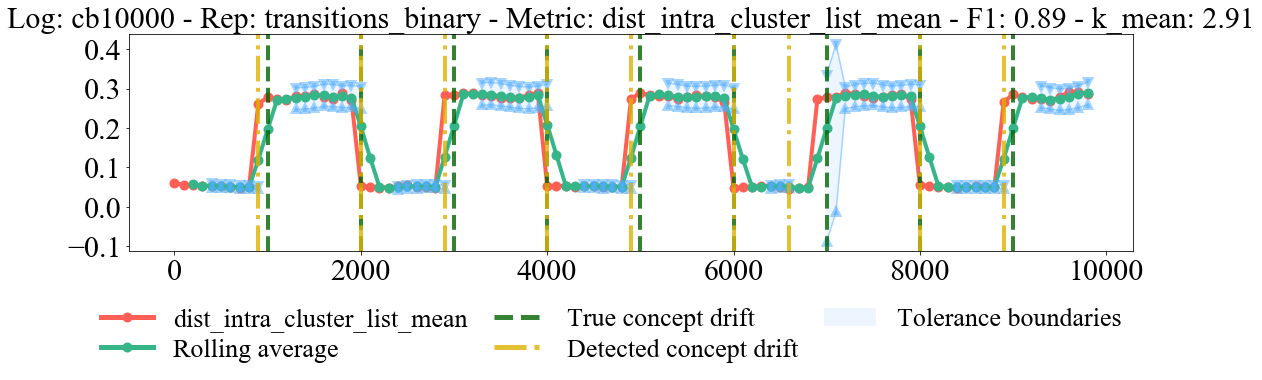

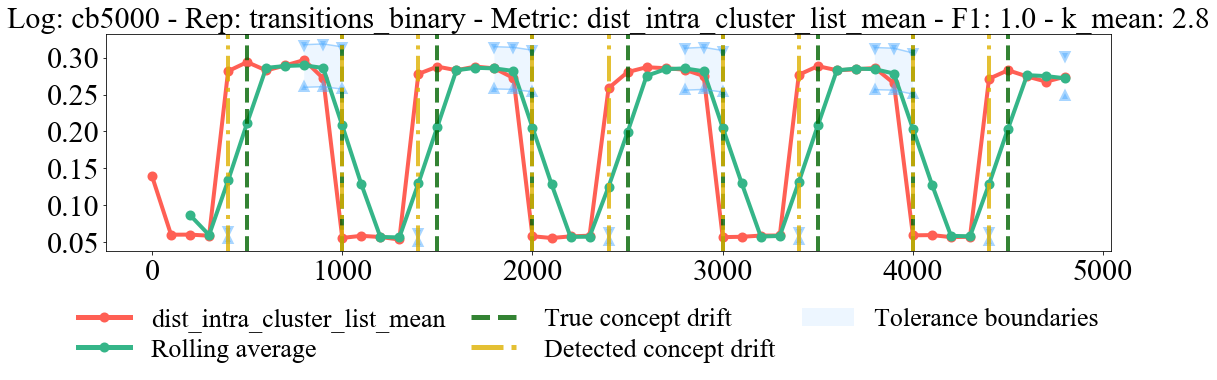

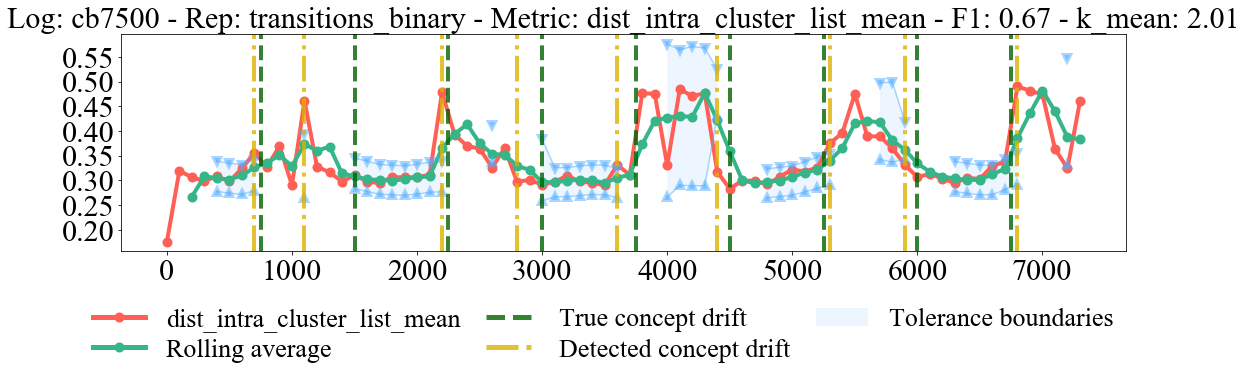

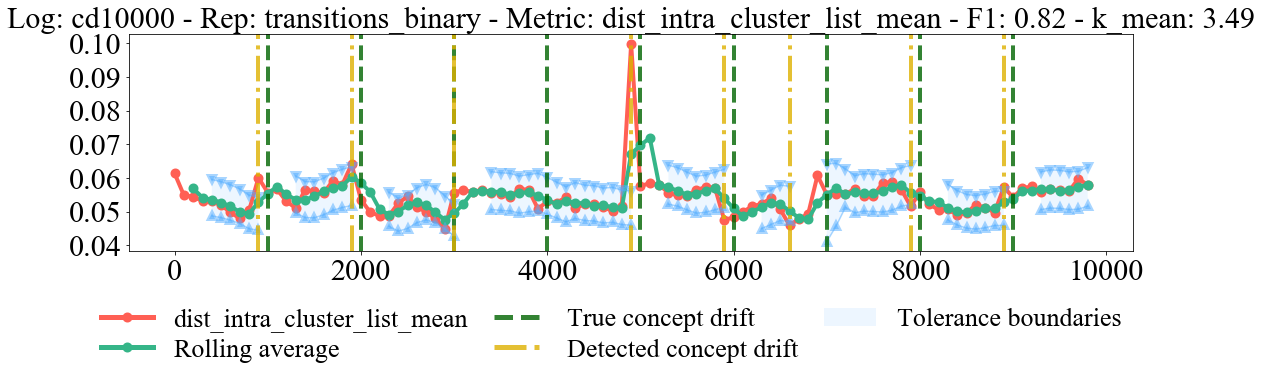

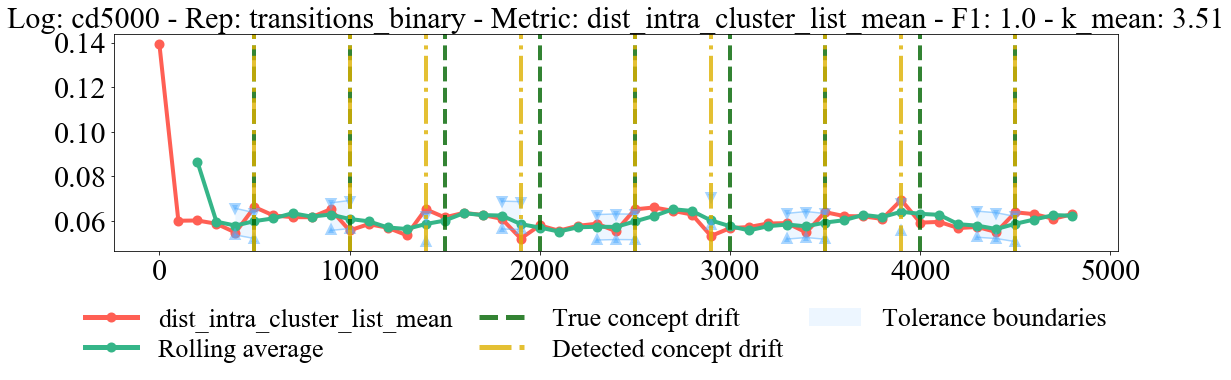

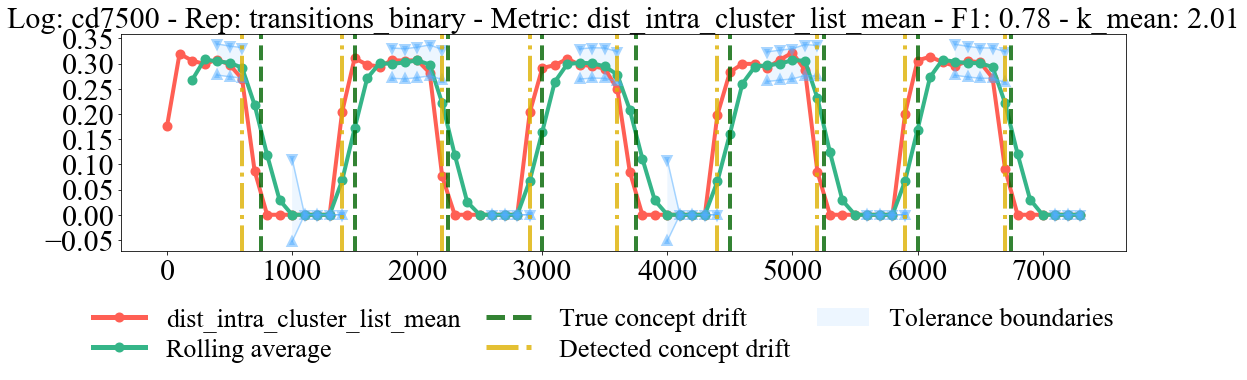

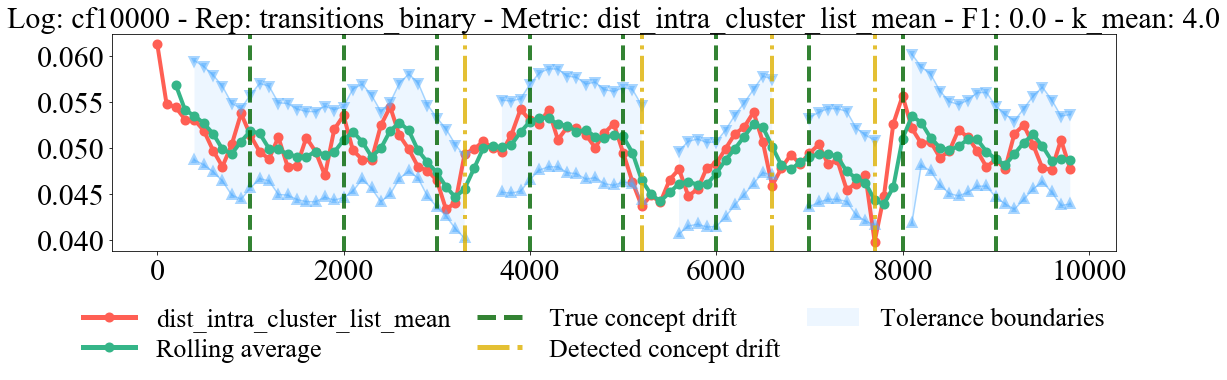

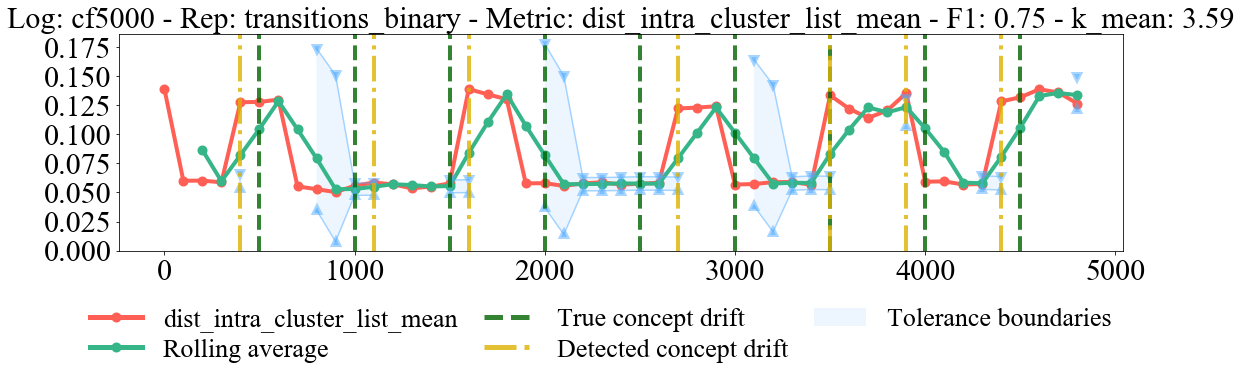

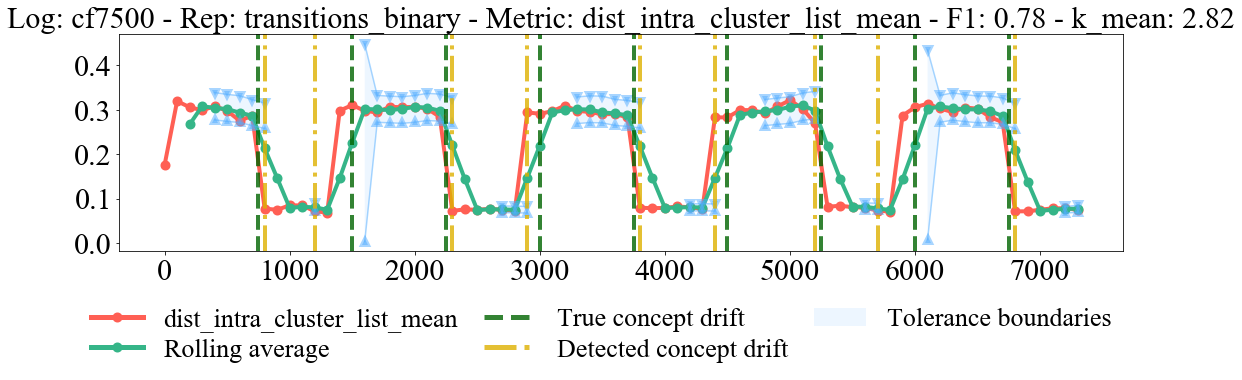

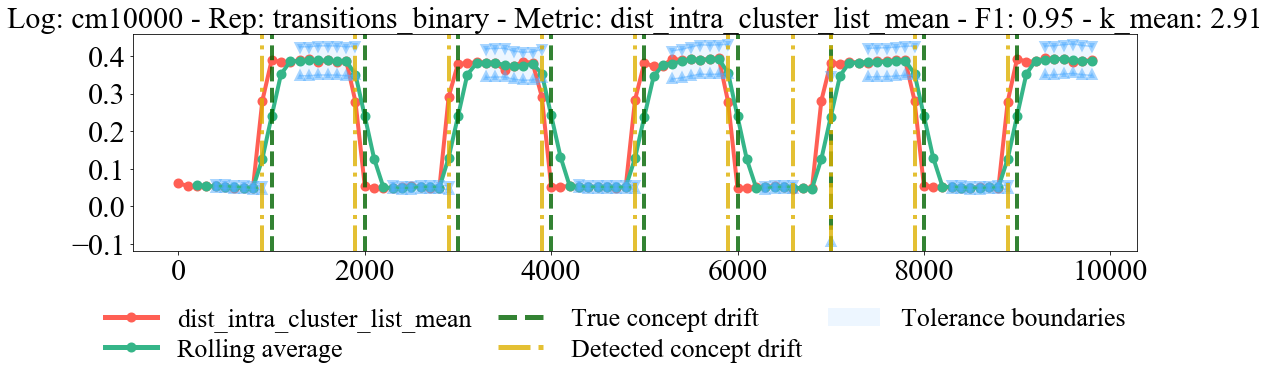

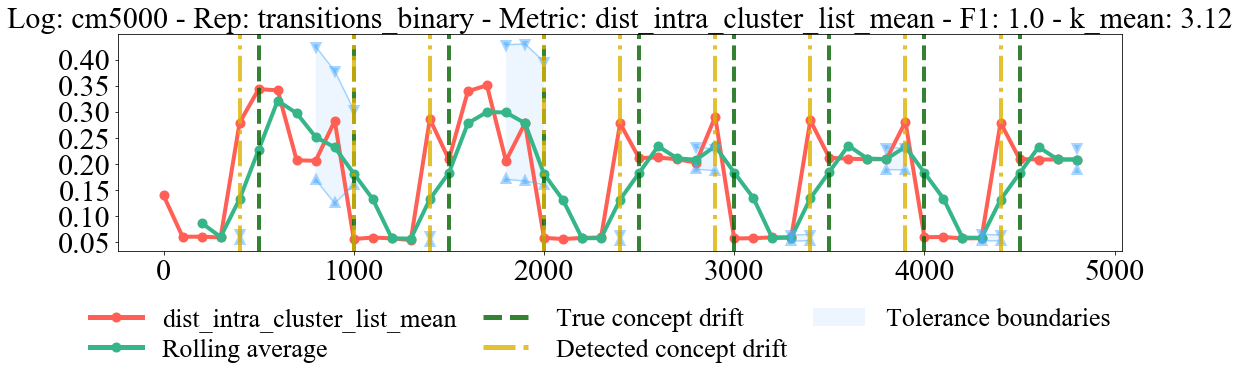

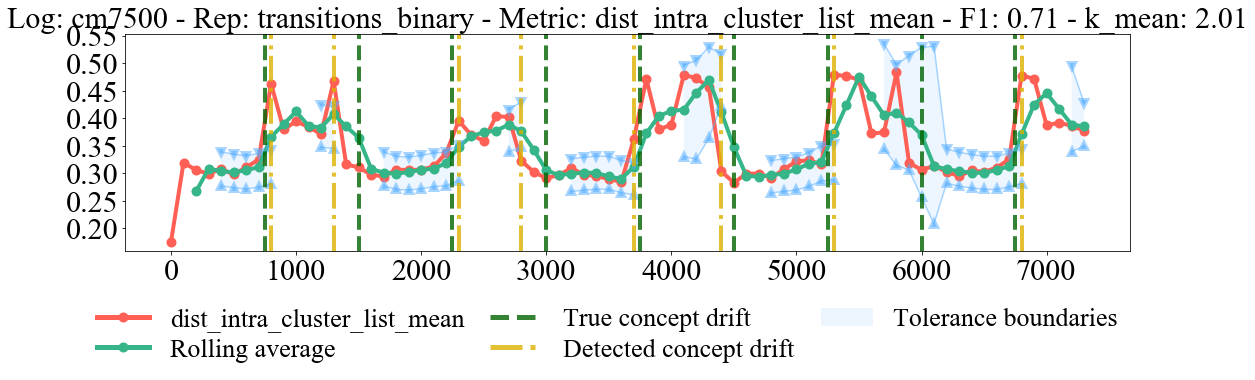

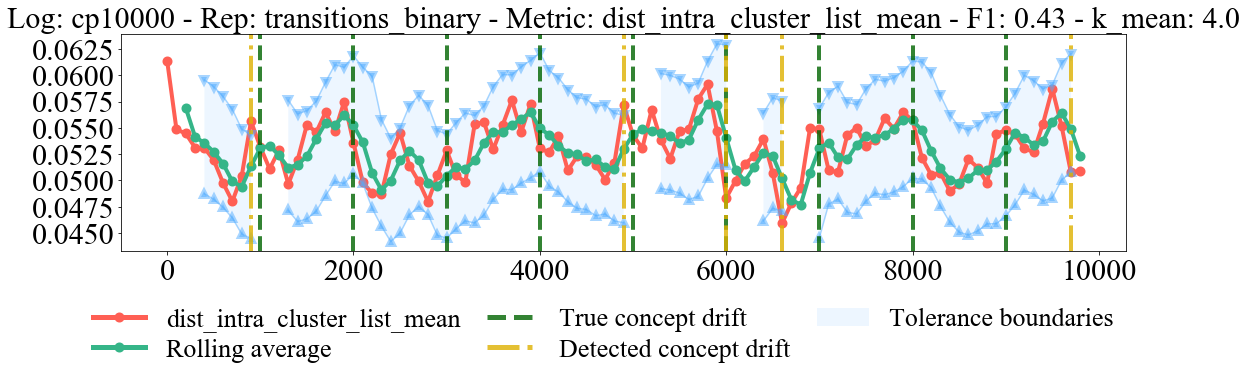

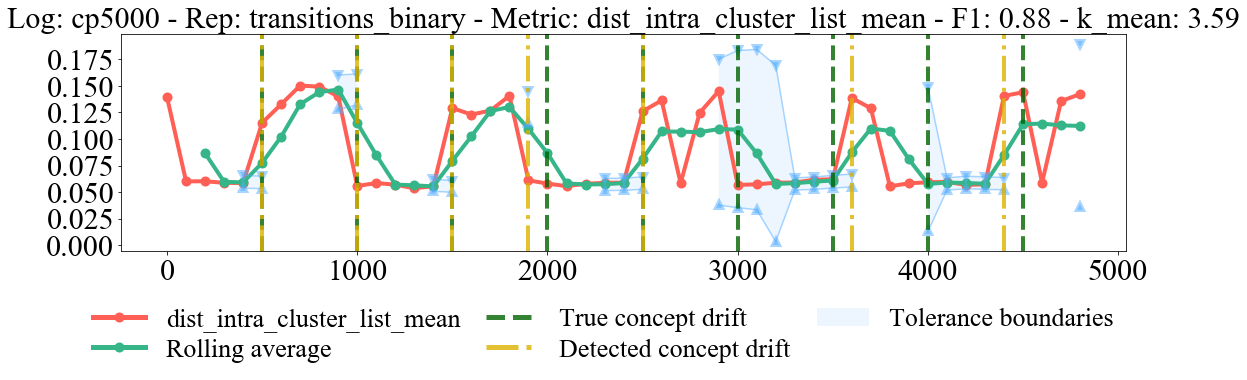

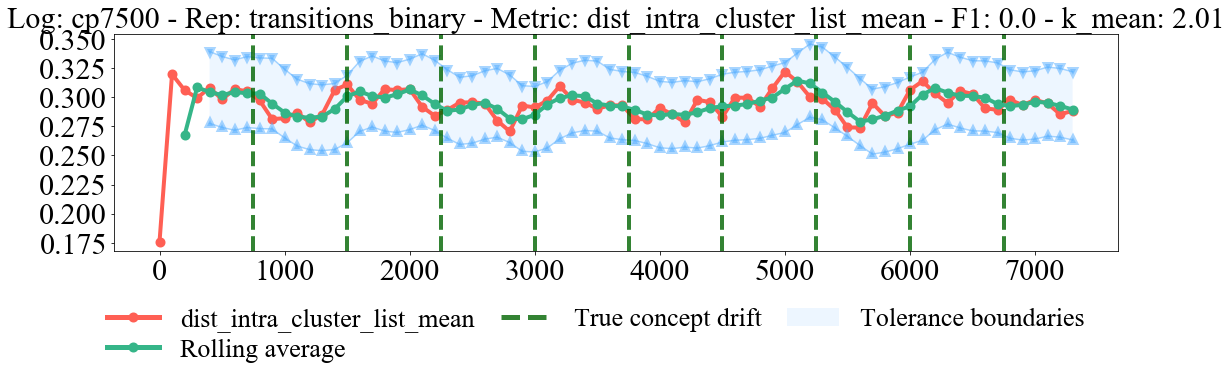

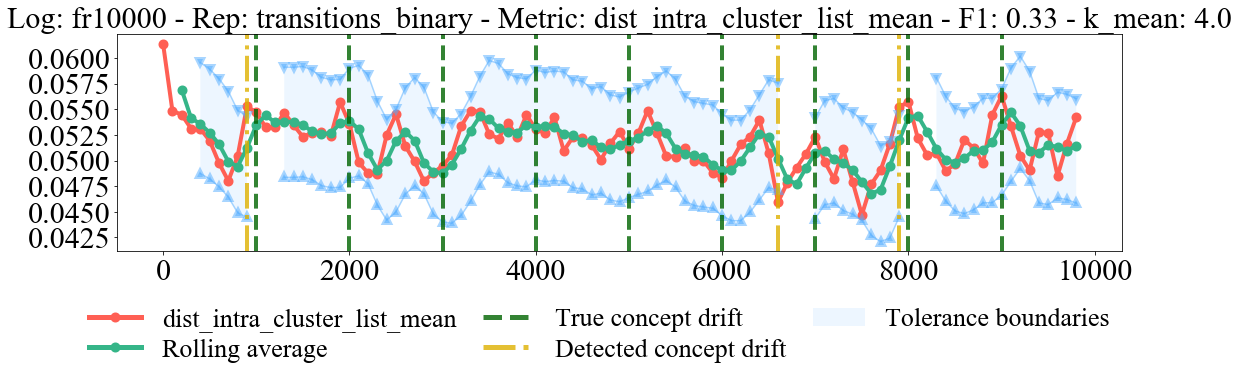

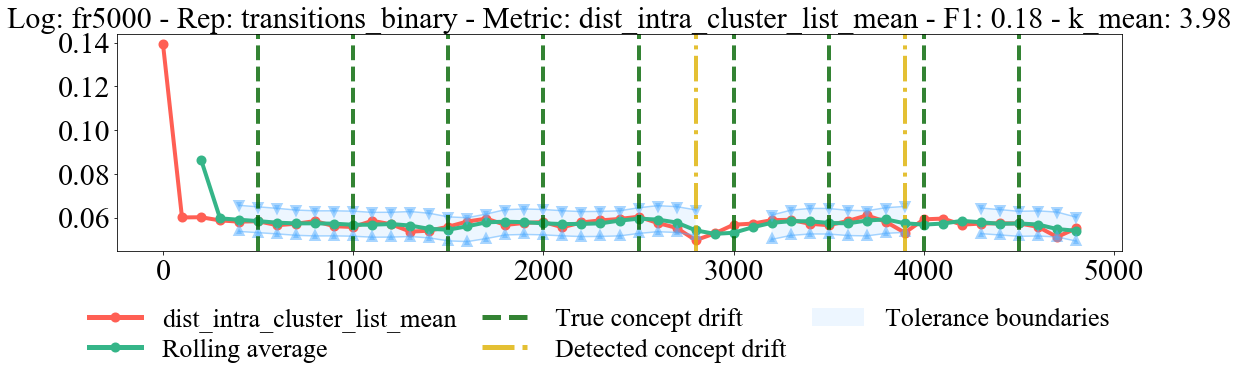

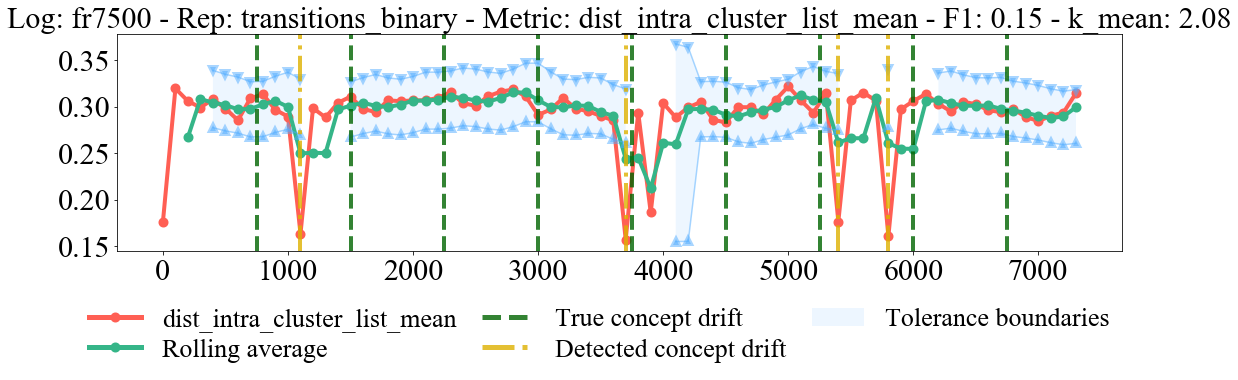

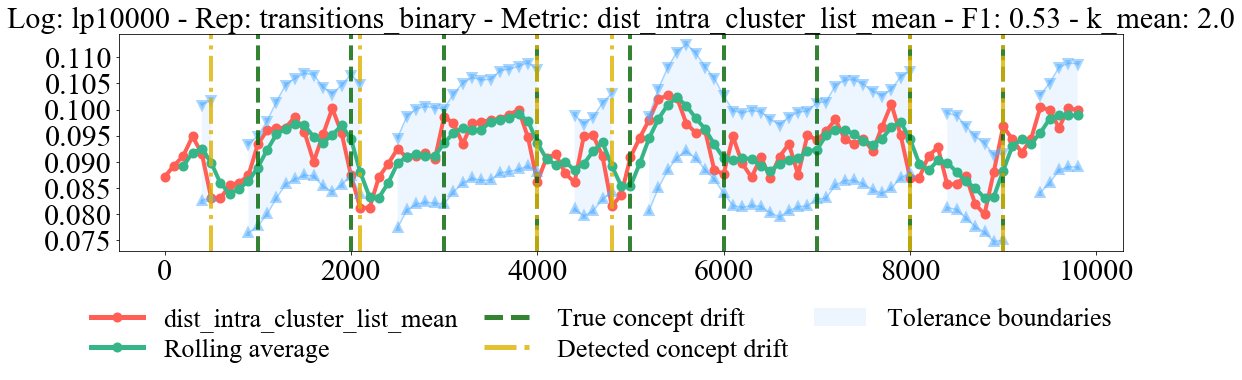

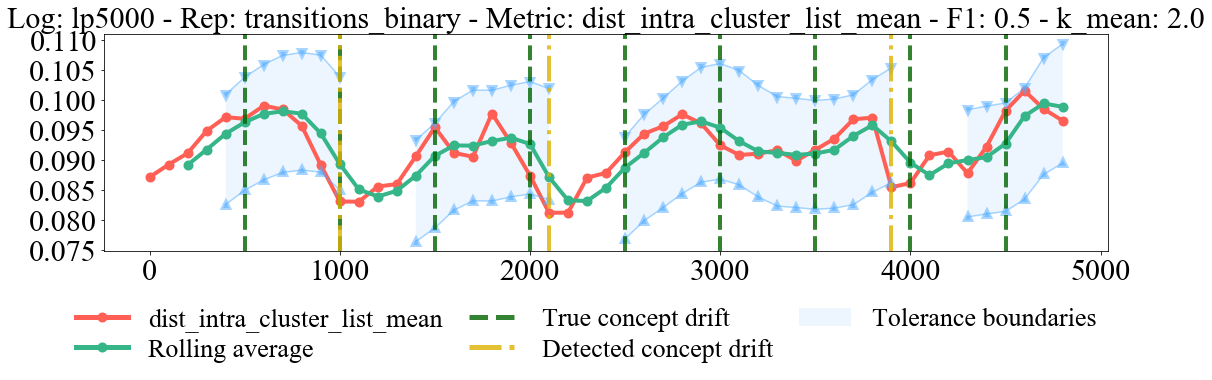

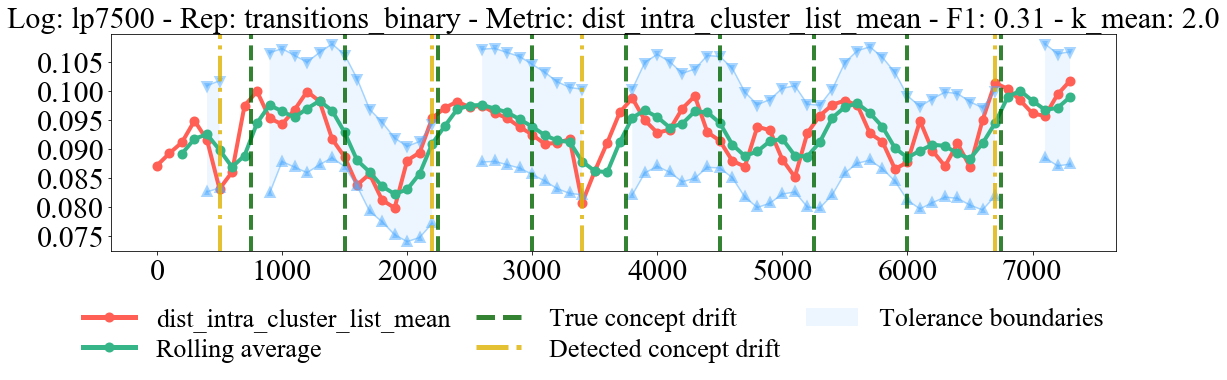

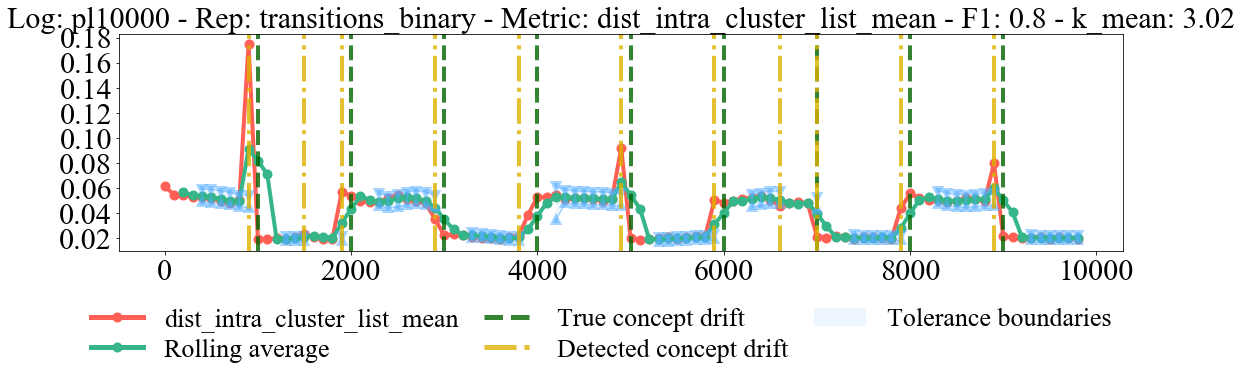

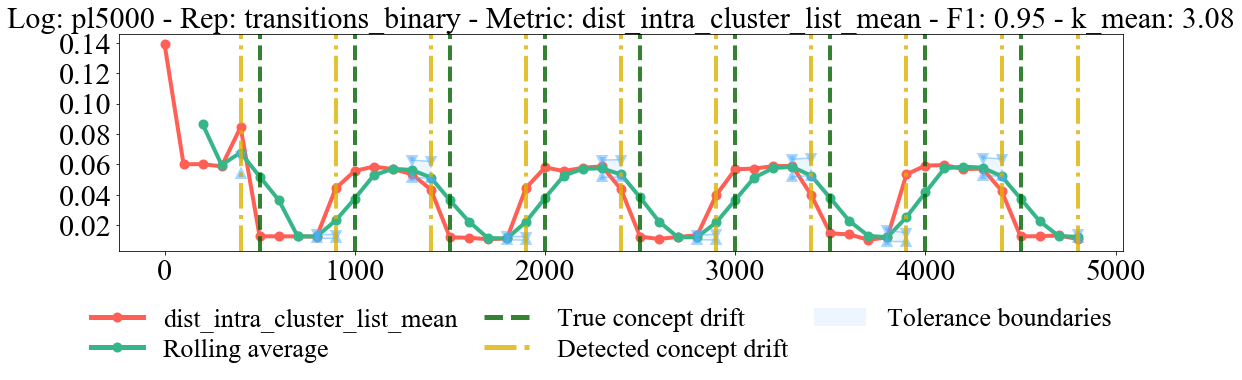

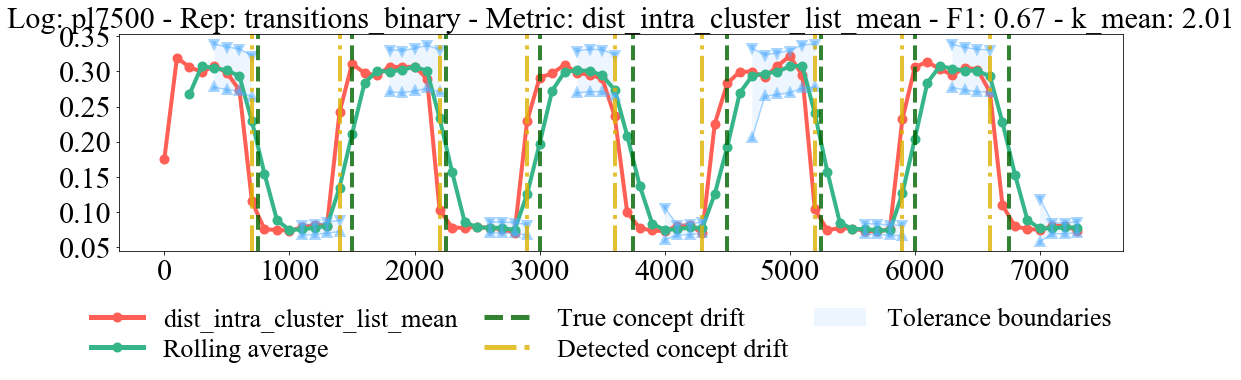

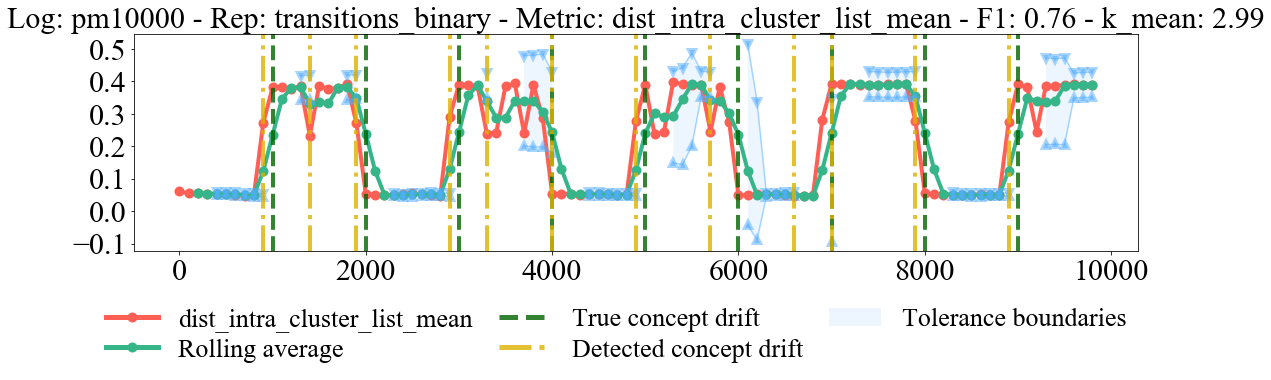

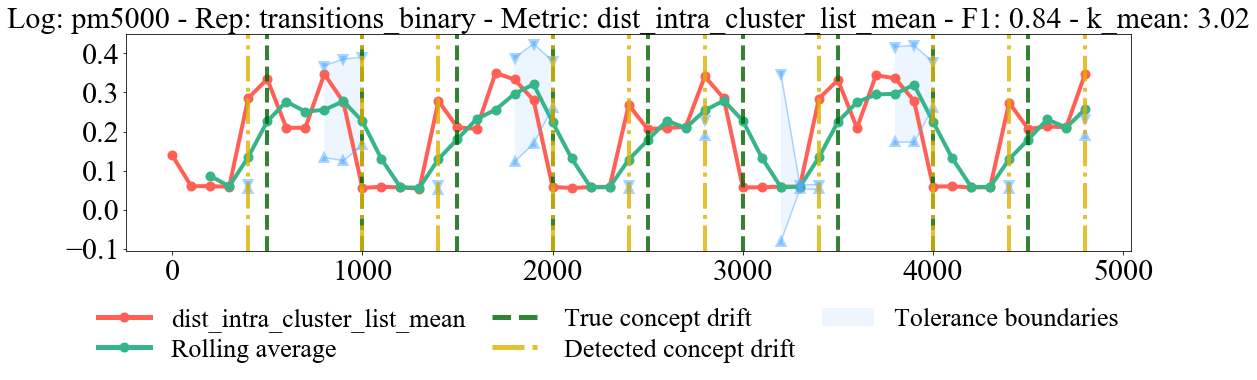

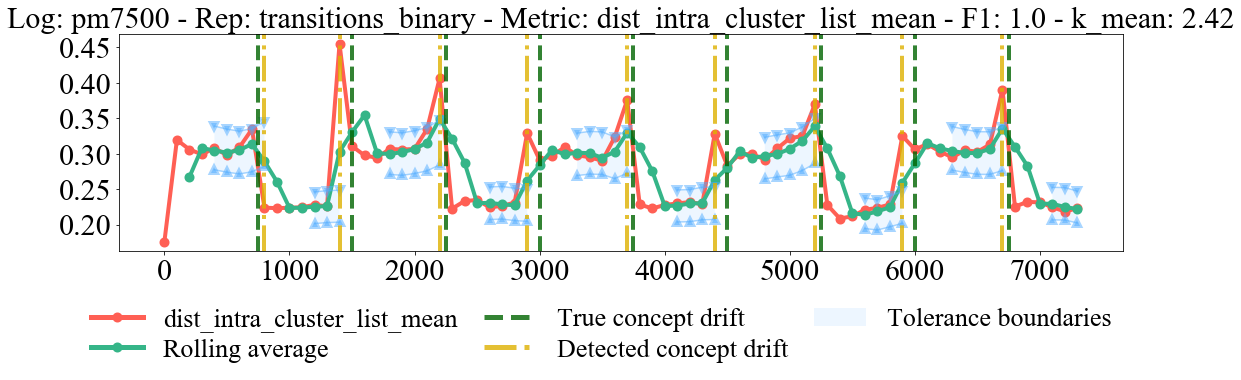

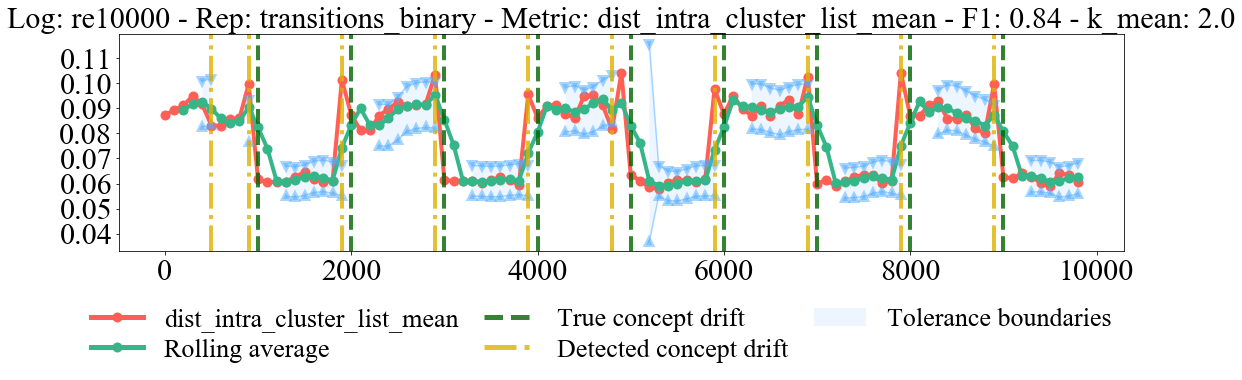

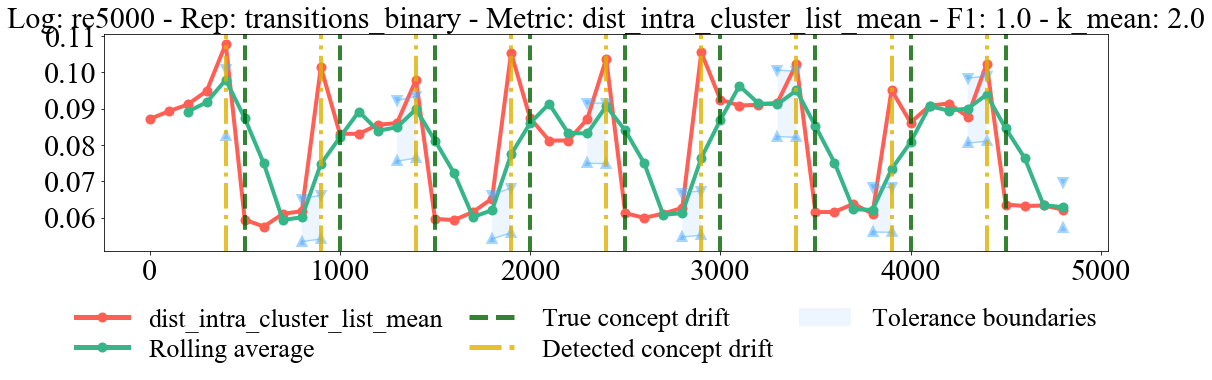

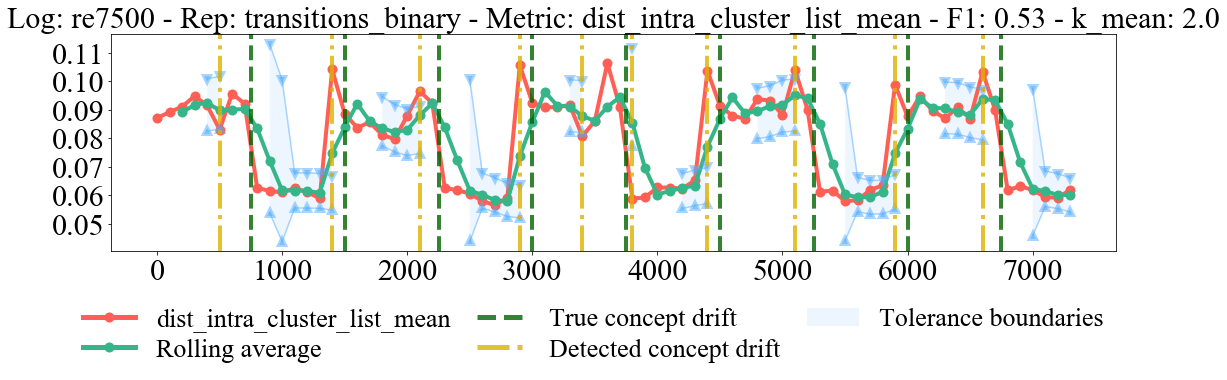

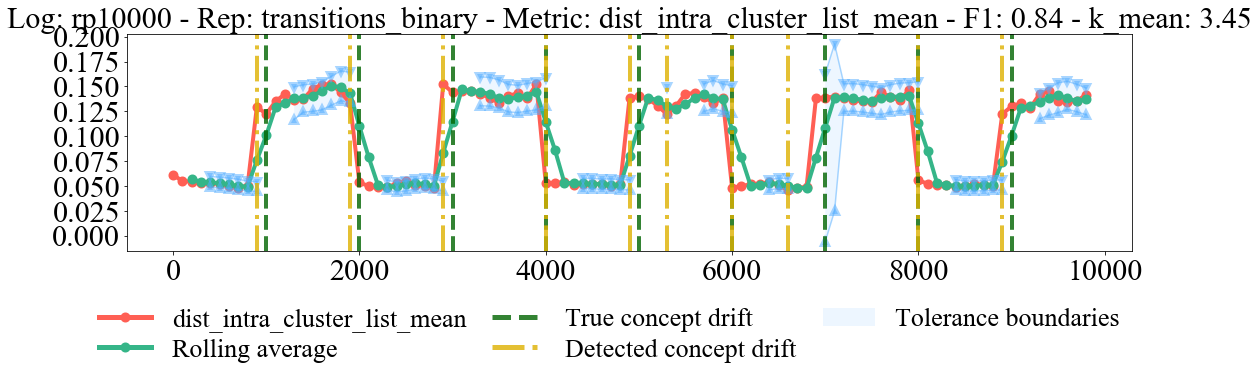

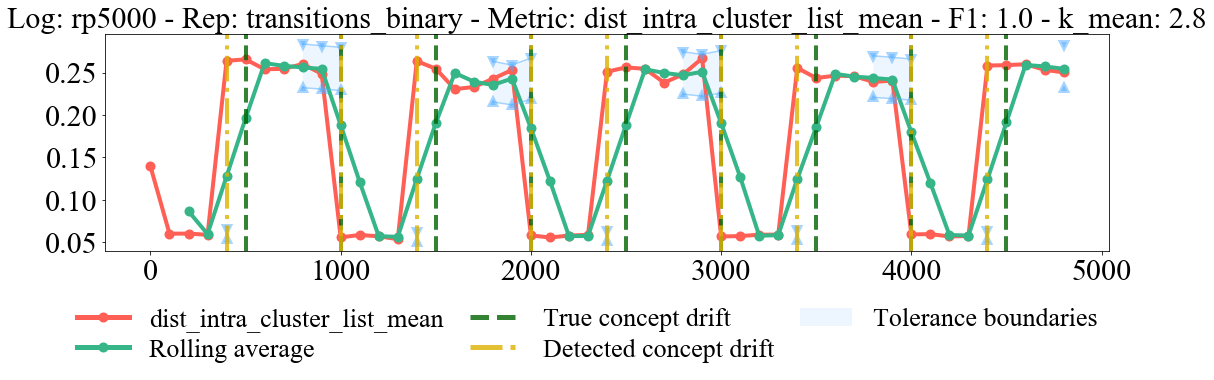

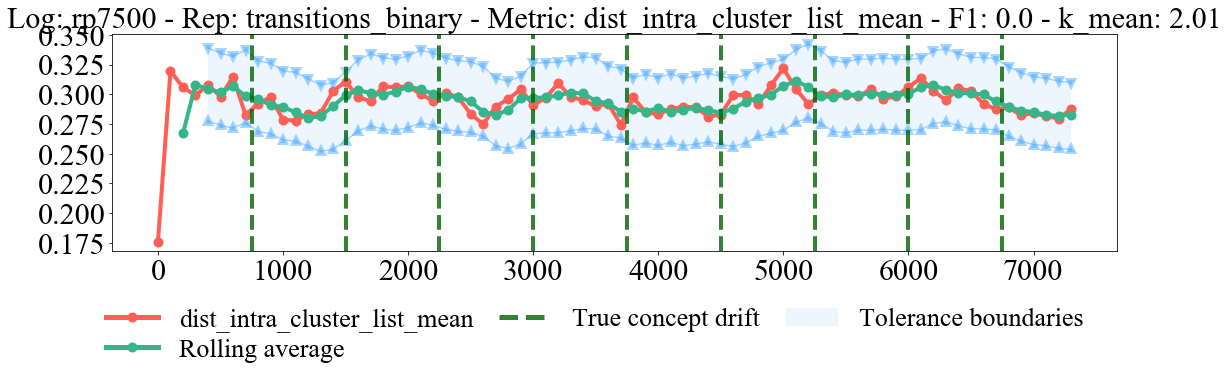

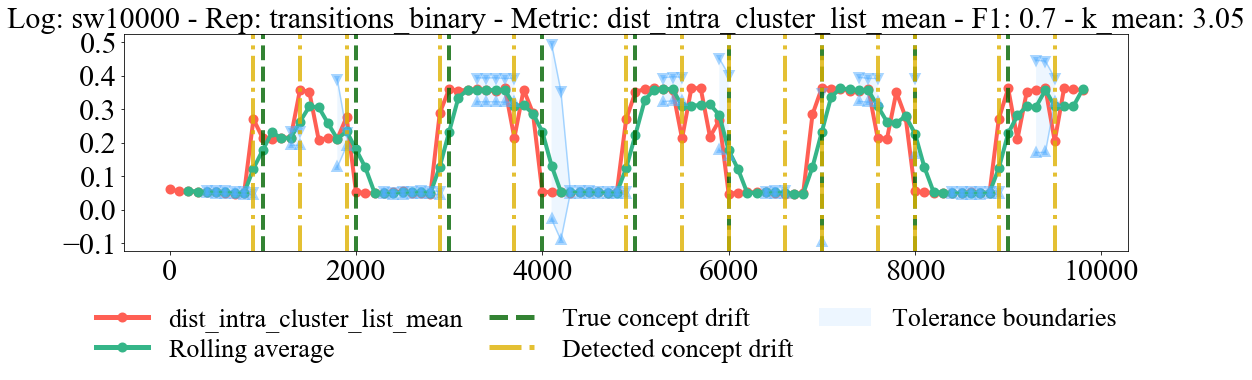

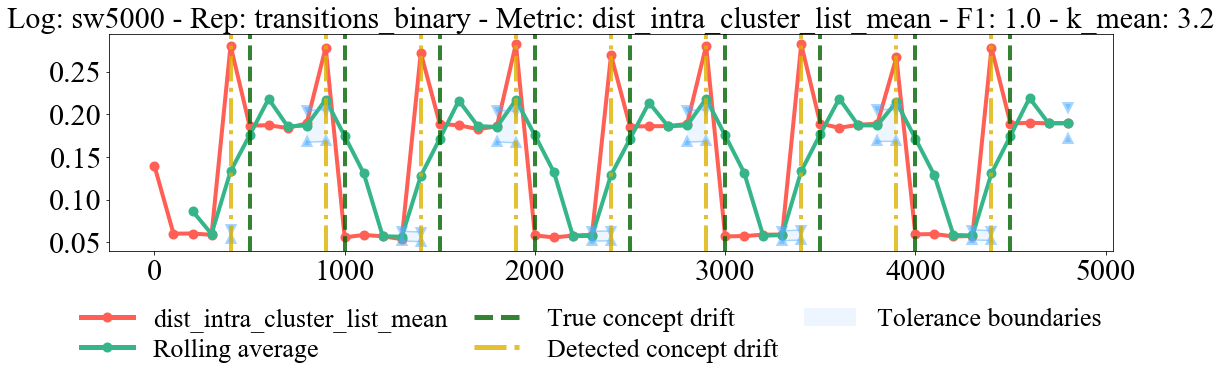

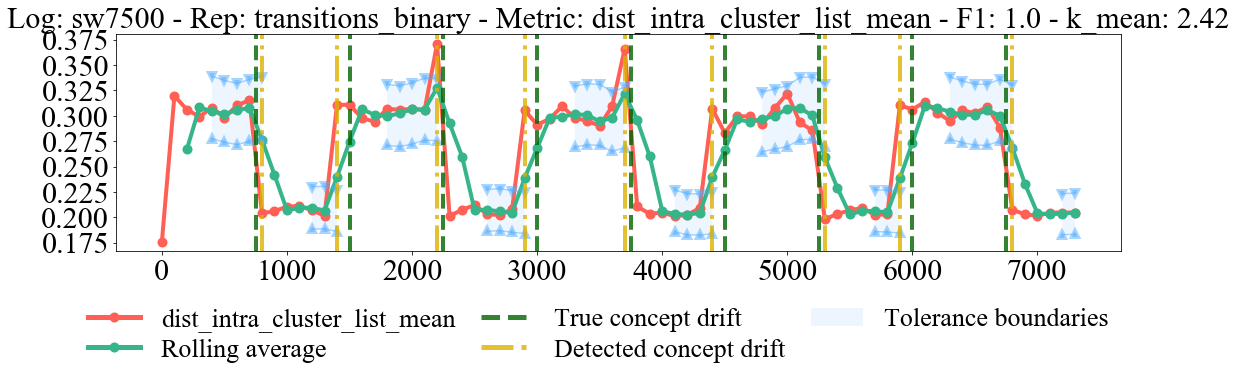

In [131]:
with PdfPages(OUTPUT_RESULTS + 'results_plot_deteccao_drift_'+model+'.pdf') as pdf:
    for row in range(0,len(show_result)):

        show_result_log = [x for x in logs if show_result.iloc[row]["tipo_mudanca"] in x 
             and str(show_result.iloc[row]["log_size"]/1000) in 
                        str(float(x.split("/")[-1][:-5].replace("k", "").replace(x.split("/")[-2],"")))]

        log_read = pm.all_prep(open(show_result_log[0]))
        tokens = lr.get_traces_as_tokens(log_read)
        
        run_df, X = off_sc.run_offline_clustering_window(
            tokens,
            objects["representation"][show_result.iloc[row]['representation']],
            objects["dim_reduct"][show_result.iloc[row]['dim_reduct']],
            objects["model"][show_result.iloc[row]['model']],
            distance_list,
            int(show_result.iloc[row]['window_size']),
#             sliding_window=False,
            sliding_step=int(show_result.iloc[row]['sliding_window'])
        )
        
#         if len(ast.literal_eval(show_result.iloc[row]['measure']))>1:
            
#             for i in range(len(ast.literal_eval(show_result.iloc[row]['measure']))):
# #                 metric = "'"+metric+"'"
# #                 print(metric)
#                 drifts, not_drifts, info = dd.detect_concept_drift(
#                     run_df,
#                     ast.literal_eval(show_result.iloc[row]['measure'])[i],
#                     rolling_window=show_result.iloc[row]['rolling_window'],
#                     std_tolerance=show_result.iloc[row]['std_tolerance'],
#                     min_tol=show_result.iloc[row]['min_tol']
#                 )
            
#                 plts.plot_deteccao_drift(
#                     run_df,
#                     ast.literal_eval(show_result.iloc[row]['measure'])[i],
#                     show_result.iloc[row]['Drifts_Found'],
#                     show_result.iloc[row]['Resp'],
#                     info['means'],
#                     info['lowers'],
#                     info['uppers'],
#                     save_png=""
#                 )

#                 plt.title("Log: " + show_result.iloc[row]["tipo_mudanca"] 
#                               + str(show_result.iloc[row]["log_size"]) 
#                               + " - Rep: " + show_result.iloc[row]["representation"] 
#                               + " - Metric: " + ast.literal_eval(show_result.iloc[row]['measure'])[i] 
#                               + " - F1: " + str(round(show_result.iloc[row]["F1"],2))
#                               + " - k_mean: " + str(round(np.mean(run_df["k"]),2))
#                           , size=30)

#                 pdf.savefig()
#                 plt.show()
                
                
#         else:
        drifts, not_drifts, info = dd.detect_concept_drift(
                run_df,
                show_result.iloc[row]['measure'],
                rolling_window=show_result.iloc[row]['rolling_window'],
                std_tolerance=show_result.iloc[row]['std_tolerance'],
                min_tol=show_result.iloc[row]['min_tol']
            )
        plts.plot_deteccao_drift(
            run_df,
            show_result.iloc[row]['measure'],
            show_result.iloc[row]['Drifts_Found'],
            show_result.iloc[row]['Resp'],
            info['means'],
            info['lowers'],
            info['uppers'],
            save_png=""
        )

        plt.title("Log: " + show_result.iloc[row]["tipo_mudanca"] + str(show_result.iloc[row]["log_size"]) 
                      + " - Rep: " + show_result.iloc[row]["representation"] 
                      + " - Metric: " + show_result.iloc[row]["measure"]
                      + " - F1: " + str(round(show_result.iloc[row]["F1"],2))
                      + " - k_mean: " + str(round(np.mean(run_df["k"]),2))
                  , size=30)

        pdf.savefig()
        plt.show()

    